In [1]:
#tensorflow==2.15.0
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


In [3]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
import pandas as pd

In [4]:
df = pd.read_csv("./sensor_data.csv")
df_test = pd.read_csv("./sensor_anomaly_data.csv")
scaler = MinMaxScaler()
arr = df.to_numpy()
arr_test = df_test.to_numpy()
train_scaled = scaler.fit_transform(arr[:,1:])
test_scaled = scaler.transform(arr_test[:,1:])
dump(scaler,open('./minmax_scaler.pkl','wb'))

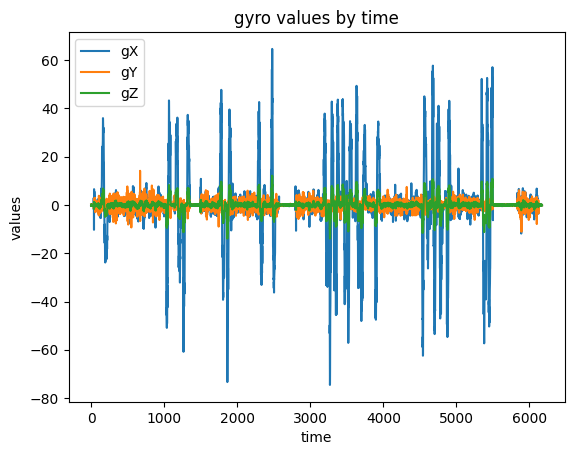

In [5]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
time = np.arange(len(df))
ax.plot(time,df['gX'],label='gX')
ax.plot(time,df['gY'],label='gY')
ax.plot(time,df['gZ'],label='gZ')
ax.set_xlabel('time')
ax.set_ylabel('values')
ax.set_title('gyro values by time')
ax.legend()
fig2.show()

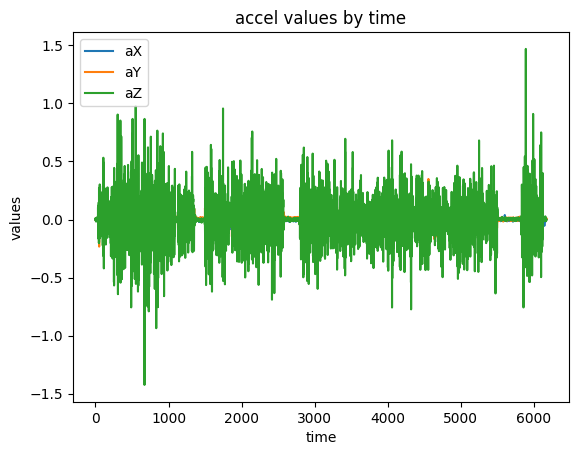

In [6]:
fig3=plt.figure()
ax = fig3.add_subplot(1,1,1)
time = np.arange(len(df))
ax.plot(time,df['aX'],label='aX')
ax.plot(time,df['aY'],label='aY')
ax.plot(time,df['aZ'],label='aZ')
ax.set_xlabel('time')
ax.set_ylabel('values')
ax.set_title('accel values by time')
ax.legend()
fig3.show()

In [7]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length].flatten()
        sequences.append(sequence)
    return np.array(sequences)

SEQ_LEN=16

sequences = create_sequences(train_scaled, SEQ_LEN)
sequences_test = create_sequences(test_scaled,SEQ_LEN)


In [8]:
print(sequences.shape)
print(sequences_test.shape)

(6156, 128)
(1049, 128)


In [9]:
def depthwise_conv2d_unit(model,filters,kernel_size):
  model.add(layers.DepthwiseConv2D(kernel_size=kernel_size,padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv2D(filters,kernel_size=1,padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  return model
def create_depthwiseConv2d_autoencoder(sequence_length,num_features):
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=sequence_length*num_features))
  model.add(layers.Reshape((sequence_length,num_features,1)))

  #encoder
  depthwise_conv2d_unit(model,16,3)
  model.add(layers.MaxPool2D(2,padding='same'))

  #decoder
  depthwise_conv2d_unit(model,16,3)
  model.add(layers.UpSampling2D(2))

  model.add(layers.Conv2D(1,kernel_size=3,activation='sigmoid',padding='same'))
  model.add(layers.Flatten())
  model.compile(optimizer='adam',loss='mse')
  return model

autoencoder = create_depthwiseConv2d_autoencoder(SEQ_LEN,8)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
#https://ctkim.tistory.com/entry/%EB%AA%A8%EB%B0%94%EC%9D%BC-%EB%84%B7
#https://medium.com/@abbesnessim/mobilenetv2-autoencoder-an-efficient-approach-for-feature-extraction-and-image-reconstruction-9c70ba58947a

In [10]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 8, 1)          0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 16, 8, 1)          10        
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 16, 8, 1)          4         
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 16, 8, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 16, 8, 16)         32        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 8, 16)         6

In [11]:
history=autoencoder.fit(sequences, sequences, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping]).history

Epoch 1/30
174/174 [==============================] - 7s 8ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 2/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0134
Epoch 3/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0145
Epoch 4/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 5/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 6/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0091
Epoch 7/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0071 - val_loss: 0.0089
Epoch 8/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 9/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 10/30
174/174 [==============================] - 1s 5ms/step - loss: 0.0066 - val_loss: 0.0082

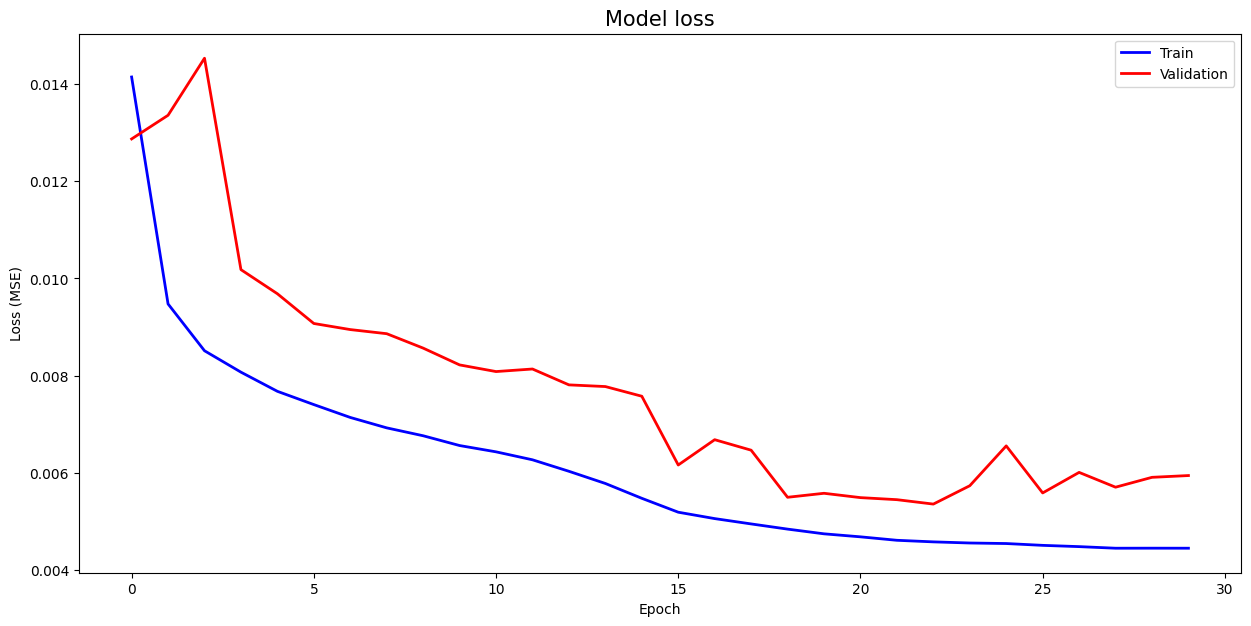

In [12]:
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss',fontsize=15)
ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [13]:
pred_train = autoencoder.predict(sequences)

193/193 [==============================] - 0s 2ms/step


In [14]:
def calculate_error(original,reconstructed):
  return np.abs(original-reconstructed)

reconstructed_error = calculate_error(sequences,pred_train)

print(reconstructed_error[0])
print(reconstructed_error[1])

[0.03467667 0.02288316 0.01169363 0.02594059 0.00737051 0.0727963
 0.03137169 0.19404726 0.03907343 0.00640586 0.00211064 0.0251853
 0.01923118 0.07026374 0.23013625 0.07634778 0.03991902 0.02247627
 0.02800587 0.04056984 0.07739888 0.00323708 0.2034767  0.39133212
 0.03807347 0.00826016 0.00912093 0.01077992 0.02991579 0.0620524
 0.2378485  0.08118935 0.03736638 0.01036775 0.03170348 0.00205251
 0.04466323 0.07506219 0.11578604 0.10356181 0.03469568 0.00908428
 0.02659141 0.01164405 0.09146385 0.07906822 0.07781954 0.0165162
 0.03397501 0.01162101 0.02815704 0.03319327 0.08678302 0.07421979
 0.02857342 0.03309146 0.03311464 0.00951948 0.02718427 0.01092028
 0.077113   0.06225034 0.04588609 0.04041892 0.03557481 0.00715669
 0.01800455 0.0349112  0.07203267 0.07843339 0.00746349 0.11102229
 0.03487275 0.01269499 0.02369638 0.00266533 0.07917998 0.05913597
 0.06186119 0.06941005 0.03907454 0.00798778 0.01421624 0.02035784
 0.09022861 0.02964357 0.02951378 0.05614511 0.03202584 0.00434286

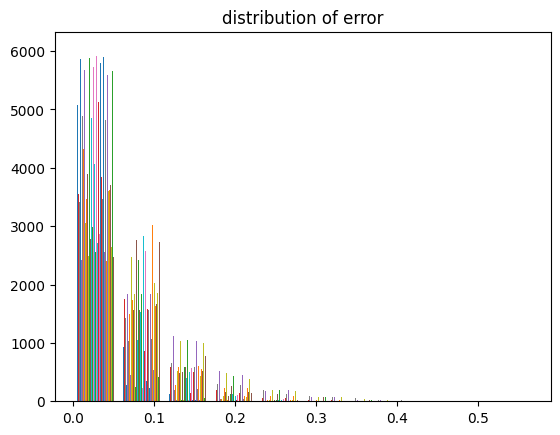

In [15]:
plt.hist(reconstructed_error)
plt.title('distribution of error')
plt.show()

In [16]:
pred_test = autoencoder.predict(sequences_test)
#print(pred_test)
pred_test.shape

33/33 [==============================] - 0s 3ms/step


(1049, 128)

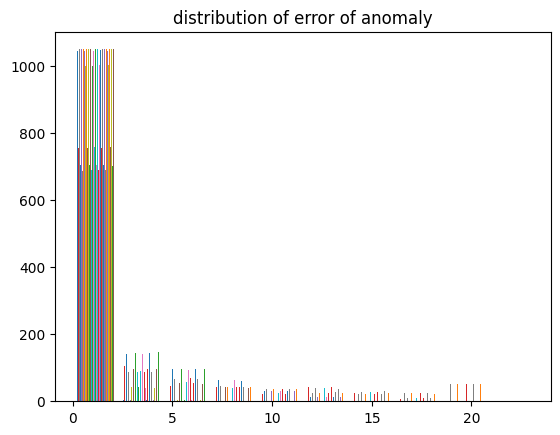

In [17]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error of anomaly')
plt.show()

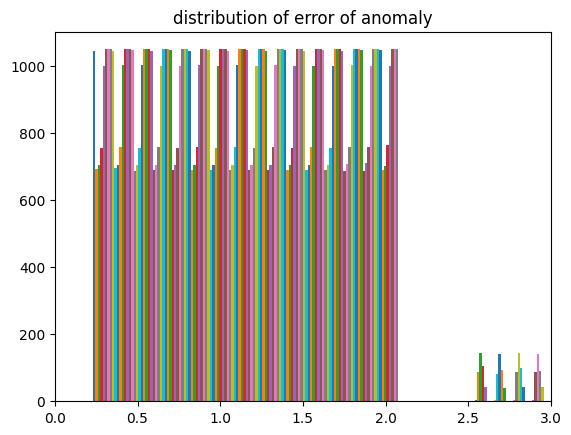

In [18]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error of anomaly')
plt.xlim([0, 3])
plt.show()

In [19]:
autoencoder.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
scaler = load(open('./minmax_scaler.pkl','rb'))

min_ = scaler.min_
scale_ = scaler.scale_

print("min_: ", min_)
print("scale_: ", scale_)

min_:  [0.53552572 0.43903253 0.53470179 0.52415995 0.40047341 0.49226948
 0.49511962 0.50342496]
scale_:  [0.00718123 0.03960096 0.03830409 3.89362613 1.71523645 0.34542076
 0.32582555 0.33624183]


In [21]:
def representative_dataset_gen():
    for i in range(50):
      if i%2==0:
        input = sequences_test[i:i+1].astype(np.float32)
      else:
        input = sequences[i:i+1].astype(np.float32)
      yield [input]

# model directory.
MODEL_DIR = "model"
#autoencoder.save(MODEL_DIR, save_format="tf",signatures=concrete_func)
autoencoder.save(MODEL_DIR, save_format="tf")

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()
with open("model.tflite","wb") as f:
    f.write(tflite_model)

In [22]:
!xxd -i model.tflite > model.cc